In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
import torch.nn as nn
import torchvision.utils as vutils
from PIL import Image
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
print( torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
GeForce GTX 1650


In [2]:
dataroot = "D:/ML datasets/unzip files/Anime girl faces database"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
workers = 2
image_size = 64
#RGB
n_channels = 3
batch_size=64
transf_anime = transforms.Compose([transforms.ToTensor(),
    #For each color channel
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

dataset_anime = datasets.ImageFolder(root=dataroot,transform=transf_anime,)

print(dataset_anime.class_to_idx)
print(len(dataset_anime.imgs))

{'size256': 0, 'size64': 1}
4868


In [3]:
image_subset_anime = torch.utils.data.Subset(dataset_anime,range(0,2434))
if image_size==64:
    image_subset_anime = torch.utils.data.Subset(dataset_anime,range(2434,4868))

dataloader = torch.utils.data.DataLoader(image_subset_anime, batch_size=batch_size,shuffle=True,num_workers=workers)

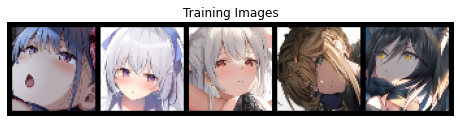

In [4]:
n_of_girls=5
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:n_of_girls], 
                                         padding=4, 
                                         normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
ngpu = 1

latent_space = 120
# Size of feature maps in generator
gen_features = 64
# Size of feature maps in discriminator
dis_features = 64
# Number of training epochs
num_epochs = 300
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
print(device)

cuda:0


In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu=ngpu
        self.netgen = nn.Sequential(
            nn.ConvTranspose2d(in_channels = latent_space, ## Instead of Upscaling Layer in 
                               out_channels = gen_features*8,
                               kernel_size = 4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(gen_features*8), #num_features
            nn.ReLU(True), # inplace 
            ## output: gen8 x 4 x 4
            nn.ConvTranspose2d(in_channels = gen_features*8, 
                               out_channels = gen_features*4,
                               kernel_size = 4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(gen_features*4), #num_features
            nn.ReLU(True), # inplace 
            ## output: gen4 x 4 x 4
            nn.ConvTranspose2d(in_channels = gen_features*4, 
                               out_channels = gen_features*2,
                               kernel_size = 4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(gen_features*2), #num_features
            nn.ReLU(True), # inplace 
            
            nn.ConvTranspose2d(in_channels = gen_features*2, 
                               out_channels = gen_features,
                               kernel_size = 4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(gen_features), #num_features
            nn.ReLU(True), # inplace 
            
            nn.ConvTranspose2d(gen_features, n_channels, 4, 2, 1, bias=False), ## features
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.netgen(input)

In [8]:
netGen = Generator(ngpu).to(device)

if ('cuda' in device) and ngpu>1:
    netGen = nn.DataParallel(netGen, list(range(ngpu)))
netGen.apply(weights_init)
print(netGen)

Generator(
  (netgen): Sequential(
    (0): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpus):
        super(Discriminator, self).__init__()
        self.ngpus = ngpus
        self.netdis = nn.Sequential(
            nn.Conv2d(n_channels, dis_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dis_features, 2*dis_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*dis_features),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(2*dis_features, 4*dis_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*dis_features),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(4*dis_features, 8*dis_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8*dis_features),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(8*dis_features, 1 , 4, 1, 0, bias=False),# Output 1 
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.netdis(input)

In [10]:
netDis = Discriminator(ngpu).to(device)

if ('cuda' in device) and ngpu>1:
    netDis = nn.DataParallel(netDis, list(range(ngpu)))
netDis.apply(weights_init)
print(netDis)

Discriminator(
  (netdis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
loss_function = nn.BCELoss()
fixed_noise = torch.randn(image_size, latent_space, 1,1, device=device)
fake_flag=0
real_flag=1

optimizerGen = torch.optim.Adam(netGen.parameters(), lr=lr,betas=(beta1, 0.999),weight_decay=0)
optimizerDis = torch.optim.Adam(netDis.parameters(), lr=lr,betas=(beta1, 0.999),weight_decay=0)

Fake:0.7762960195541382, True:0.61875981092453, Gen Error:6.367404460906982, Epoch:0
Fake:7.73245938034961e-06, True:0.8941429853439331, Gen Error:21.181013107299805, Epoch:1
Fake:0.3601558804512024, True:0.8423117399215698, Gen Error:6.298447608947754, Epoch:2
Fake:0.9331936836242676, True:0.9597996473312378, Gen Error:2.7802891731262207, Epoch:3
Fake:0.5785976648330688, True:0.7965713739395142, Gen Error:4.142329216003418, Epoch:4
Fake:0.28707247972488403, True:0.9169132113456726, Gen Error:5.505878925323486, Epoch:5
Fake:0.12561264634132385, True:0.731422483921051, Gen Error:6.059788703918457, Epoch:6
Fake:0.5170210599899292, True:0.9312122464179993, Gen Error:11.078499794006348, Epoch:7
Fake:0.01359633170068264, True:0.7969136238098145, Gen Error:6.653306007385254, Epoch:8
Fake:0.0012616594322025776, True:0.3349758982658386, Gen Error:7.839044570922852, Epoch:9
Fake:0.9442307949066162, True:0.9933335185050964, Gen Error:2.829953670501709, Epoch:10
Fake:0.3405807614326477, True:0.85

Fake:0.18856607377529144, True:0.8668122291564941, Gen Error:4.864004611968994, Epoch:93
Fake:0.1264057159423828, True:0.9157699346542358, Gen Error:4.305134296417236, Epoch:94
Fake:0.5720402002334595, True:0.9818174242973328, Gen Error:7.4283318519592285, Epoch:95
Fake:0.8622313737869263, True:0.9925222396850586, Gen Error:11.685060501098633, Epoch:96
Fake:0.3727349638938904, True:0.9921583533287048, Gen Error:8.027911186218262, Epoch:97
Fake:0.9670801758766174, True:0.9993672966957092, Gen Error:10.332751274108887, Epoch:98
Fake:0.03499661758542061, True:0.7124356031417847, Gen Error:3.459311008453369, Epoch:99
Fake:0.5443654656410217, True:0.9851038455963135, Gen Error:9.347314834594727, Epoch:100
Fake:0.04288110509514809, True:0.8954975605010986, Gen Error:4.666484832763672, Epoch:101
Fake:0.2902226448059082, True:0.9752081632614136, Gen Error:6.7733964920043945, Epoch:102
Fake:0.036239996552467346, True:0.8713818788528442, Gen Error:3.9953575134277344, Epoch:103
Fake:0.20727780461

Fake:0.256680428981781, True:0.9909261465072632, Gen Error:7.692389965057373, Epoch:185
Fake:0.06022096425294876, True:0.9824930429458618, Gen Error:4.985998153686523, Epoch:186
Fake:0.20764431357383728, True:0.993353009223938, Gen Error:7.392116546630859, Epoch:187
Fake:0.0021495092660188675, True:0.8498322367668152, Gen Error:5.628614902496338, Epoch:188
Fake:0.9014058113098145, True:0.9991658329963684, Gen Error:15.689990997314453, Epoch:189
Fake:0.5614764094352722, True:0.9920000433921814, Gen Error:12.155750274658203, Epoch:190
Fake:0.35502889752388, True:0.9884663224220276, Gen Error:9.600808143615723, Epoch:191
Fake:0.023289883509278297, True:0.9172172546386719, Gen Error:4.7212395668029785, Epoch:192
Fake:0.04330483451485634, True:0.9824292659759521, Gen Error:5.149898052215576, Epoch:193
Fake:0.024910051375627518, True:0.8869513869285583, Gen Error:5.401961803436279, Epoch:194
Fake:0.06575113534927368, True:0.9759174585342407, Gen Error:5.907304763793945, Epoch:195
Fake:0.5954

Fake:0.005091832019388676, True:0.9377832412719727, Gen Error:6.162364482879639, Epoch:277
Fake:0.020691119134426117, True:0.9744564294815063, Gen Error:4.850933074951172, Epoch:278
Fake:0.38936471939086914, True:0.9989696741104126, Gen Error:12.52490234375, Epoch:279
Fake:0.9954262971878052, True:0.9994751214981079, Gen Error:11.37295150756836, Epoch:280
Fake:0.02129150740802288, True:0.9400085210800171, Gen Error:6.791128635406494, Epoch:281
Fake:0.8553720712661743, True:0.99967360496521, Gen Error:16.296852111816406, Epoch:282
Fake:0.1950351893901825, True:0.9801266193389893, Gen Error:7.205872535705566, Epoch:283
Fake:0.18197236955165863, True:0.9960236549377441, Gen Error:6.761197090148926, Epoch:284
Fake:0.33954665064811707, True:0.995795488357544, Gen Error:9.43012809753418, Epoch:285
Fake:0.023894459009170532, True:0.9852614402770996, Gen Error:5.031551361083984, Epoch:286
Fake:0.12149982154369354, True:0.9950869083404541, Gen Error:5.266686916351318, Epoch:287
Fake:0.109843216

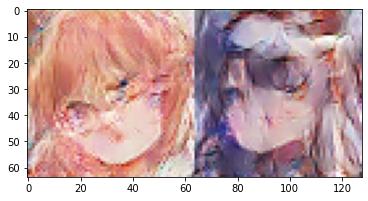

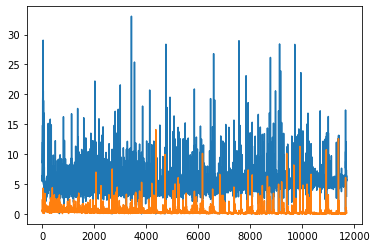

In [12]:
img_list=[]
G_loss, D_loss=[],[]

iters=0

for epoch in range(num_epochs):
    for i,data in enumerate(dataloader):
        ## Discriminator Network:  -> log(D(x)) + log(1-D(x))
        netDis.zero_grad()## resets gradients
        real_image = data[0].to(device) ## data[0] is the image, data[1] is the label (64[1] or 256[0])
        b_size=real_image.size(0) ## batch size eg (128,64,64) b_size=128
        label = torch.full((b_size,), real_flag, ## Can I use torch.ones? I guess not because
                           dtype=torch.float, device=device)  ## of the device, float options
        
        ## Discriminator Output with a real image
        output = netDis(real_image).view(-1) ## [bs, 1,1,1] -> [bs]
        errDis_real = loss_function(output, label) ## comparing inference vs real/fake flags
        errDis_real.backward()
        d_real_mean = output.mean().item()
        
        ## Generator Output with random seed
        label.fill_(fake_flag) ## xx_ replaces value in PT
        noise = torch.randn(b_size,latent_space, 1,1, device=device) ##normal dist random number
        fake_image = netGen(noise)
        
        ## Discriminator Output with fake image
        output = netDis(fake_image.detach()).view(-1) ## Detach to from the netGen!! 
        errDis_fake = loss_function(output, label)
        errDis_fake.backward()
        d_fake_mean  = output.mean().item()
        
        ## Total Error from the Discriminator
        errorDis = errDis_real + errDis_fake
        
        ## Actual update inside the netDis network
        optimizerDis.step()
        
        ## #######################################
        ## Generator Training
        netGen.zero_grad() ## ALWAYS BEFORE TRAINING
        label.fill_(real_flag)
        output = netDis(fake_image).view(-1) ##
        
        error_Gen = loss_function(output, label)
        error_Gen.backward()
        g_gen_mean=error_Gen.mean().item()
        
        optimizerGen.step()
        
        
        if (i%500==0):
            print(f"Fake:{d_fake_mean}, True:{d_real_mean}, Gen Error:{g_gen_mean}, Epoch:{epoch}")
            test_image=netGen(noise).detach().cpu()
            plt.imshow(np.transpose(vutils.make_grid(test_image[:2], 
                                        padding=0, 
                                        normalize=True).cpu(),(1,2,0)))
            
#         wandb.log({"Fake":d_fake_mean, "True":d_real_mean, "Gen Error":g_gen_mean,
#                        "error_Gen":error_Gen, "error_Dis":errorDis})
        G_loss.append(error_Gen.item())
        D_loss.append(errorDis.item())
        #print(f"Fake:{d_fake_mean}, True:{d_real_mean}, Gen Error:{g_gen_mean}")    
#         print(G_loss[-1],D_loss[-1])
        #break
#     break

#torch.save(netGen, 'Generator_epoch_{}.pth'.format(num_epochs))
#torch.save(netDis, 'Discriminator_epoch_{}.pth'.format(num_epochs))

#print('Model saved.')

plt.figure(11)
plt.plot(G_loss)
plt.plot(D_loss)

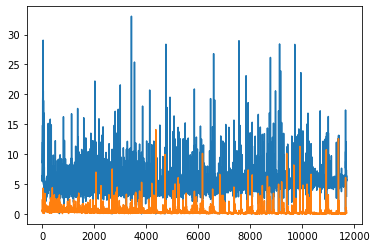

In [13]:
plt.figure(11)
plt.plot(G_loss)
plt.plot(D_loss)

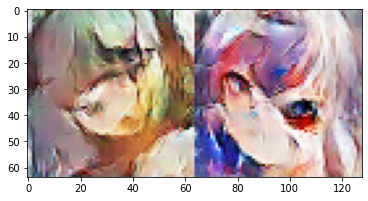

In [14]:
test_image=netGen(noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(test_image[:2], padding=0, normalize=True).cpu(),(1,2,0)))